## Data

In [5]:
!wget https://snap.stanford.edu/data/web-NotreDame.txt.gz

--2023-11-26 23:18:33--  https://snap.stanford.edu/data/web-NotreDame.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3708538 (3.5M) [application/x-gzip]
Saving to: 'web-NotreDame.txt.gz'

web-NotreDame.txt.g  13%[=>                  ] 496.00K  27.8KB/s    in 2m 16s  

2023-11-26 23:20:50 (3.65 KB/s) - Connection closed at byte 507904. Retrying.

--2023-11-26 23:20:51--  (try: 2)  https://snap.stanford.edu/data/web-NotreDame.txt.gz
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 3708538 (3.5M), 3200634 (3.1M) remaining [application/x-gzip]
Saving to: 'web-NotreDame.txt.gz'

web-NotreDame.txt.g  30%[++===>              ]   1.08M  --.-KB/s    in 15m 49s 

2023-11-26 23:37:12 (656 B/s) - Read error at byte 1130496/3708538 (Conn

In [21]:
!gzip -dv web-NotreDame.txt.gz

gzip: web-NotreDame.txt.gz: No such file or directory


In [22]:
!head web-NotreDame.txt

# Directed graph (each unordered pair of nodes is saved once): web-NotreDame.txt 
# University of Notre Dame web graph from 1999 by Albert, Jeong and Barabasi
# Nodes: 325729 Edges: 1497134
# FromNodeId	ToNodeId
0	0
0	1
0	2
0	3
0	4
0	5


In [23]:
!sed -n '5,1004p;1005q' web-NotreDame.txt > web-small.txt

In [24]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Defaulting to user installation because normal site-packages is not writeable
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [31]:
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatProgress

## Network stream

In [32]:
class NetworkEdgeStream:

  def __init__(self, filename, show_progress_bar):
    self.filename = filename
    self.show_progress_bar = show_progress_bar

  def get_edges(self):
    with open(self.filename, "r") as f:
      lines = f.readlines()
      if self.show_progress_bar:
        lines = tqdm(lines)
      for line in lines:
        line = line.strip()
        if line.startswith("#"):
          continue
        else:
          yield tuple(map(int, line.split("\t")))

## Reservoir sampling

In [34]:
class ReservoirSampler:

  def __init__(self, capacity):
    self.M = capacity
    self.reservoir = []
    self.counter = 0

  def add(self, element):
    self.counter += 1
    if len(self.reservoir) < self.M:
      self.reservoir.append(element)
      return True
    elif self.M / self.counter >= random.random():
      eviction_index = random.randint(0, self.M - 1)
      self.reservoir[eviction_index] = element
      return True
    return False

## Streaming triangles

In [35]:
class StreamingTriangles:

  def __init__(self, edge_stream, edge_capacity, wedge_capacity):
    self.edge_stream = edge_stream
    self.edge_capacity = edge_capacity
    self.edge_res = [None for i in range(edge_capacity)] # edges are tuples (a,b)
    self.wedge_capacity = wedge_capacity
    self.wedge_res = [None for i in range(wedge_capacity)] # wedges are tuples of format ((a,b),(b,c))
    self.is_closed = [False for i in range(wedge_capacity)]
    self.tot_wedges = 0
    self.counter = 0
    self.ends_with_dict = dict()

  def run(self):
    for edge in self.edge_stream.get_edges():
      _ = self.add_edge(edge)

  def run_return_estimates(self):
    for edge in self.edge_stream.get_edges():
      yield self.add_edge(edge)

  def add_edge(self, edge):
    self.counter += 1
    self._update(edge)
    rho = self._calculate_is_closed_fraction()
    kappa_t = 3 * rho
    T_t = (rho * self.counter ** 2) / (self.edge_capacity * (self.edge_capacity - 1)) * self.tot_wedges
    return kappa_t, T_t

  def _calculate_is_closed_fraction(self):
    return sum(self.is_closed) / len(self.is_closed)

  def _update(self, edge):
    self._check_if_closes_wedge(edge)
    edge_res_updated = self._update_edge_res(edge)
    if edge_res_updated:
      self._update_wedges(edge)

  def _check_if_closes_wedge(self, edge):
    for i,wedge in enumerate(self.wedge_res):
      if wedge is not None and (wedge[1][1] == edge[0] and wedge[0][0] == edge[1]):
        self.is_closed[i] = True

  def _update_edge_res(self, new_edge):
    has_changed = False
    for i in range(self.edge_capacity):
      if random.random() <= 1 / self.counter:
        previous = self.edge_res[i]
        self.edge_res[i] = new_edge
        self._replace_edge_in_ends_dict(previous, new_edge)
        has_changed = True
    return has_changed

  def _replace_edge_in_ends_dict(self, old_edge, new_edge):
    if old_edge is not None and old_edge in self.ends_with_dict:
      self.ends_with_dict[old_edge[1]].remove(old_edge)
      if len(self.ends_with_dict[old_edge[1]]) == 0:
        del self.ends_with_dict[old_edge[1]]
    if new_edge[1] in self.ends_with_dict:
      self.ends_with_dict[new_edge[1]].add(new_edge)
    else:
      self.ends_with_dict[new_edge[1]] = {new_edge}

  def _update_wedges(self, edge):
    wedges = self._determine_wedges(self.edge_res)
    self.tot_wedges = len(wedges)
    N_t = [w for w in wedges if edge in w]
    new_wedges = len(N_t)
    if self.tot_wedges != 0:
      for i in range(self.wedge_capacity):
        if random.random() <= new_wedges / self.tot_wedges:
          w = N_t[random.randint(0, new_wedges - 1)]
          self.wedge_res[i] = w
          self.is_closed[i] = False

  def _determine_wedges(self, edges):
    wedges = []
    for edge in edges:
      (a, b) = edge
      if a in self.ends_with_dict:
        for e in self.ends_with_dict[a]:
          wedges.append((e, edge))
    return wedges


## Evaluation

First, test the algorithm on a small subgraph containing 1000 edges.

In [88]:
st_test = StreamingTriangles(NetworkEdgeStream("web-small.txt", True), 200, 250)

In [89]:
test_results = []
for e in st_test.run_return_estimates():
  test_results.append(e)

100%|██████████| 1000/1000 [00:00<00:00, 22423.56it/s]


In [90]:
print(test_results)
print(test_results[-1][1])

[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.12, 0.1263437185929648), (0.10799999999999998, 0.12049055276381909), (0.10799999999999998, 0.13097487437185928), (0.10799999999999998, 0.14080974874371857), (0.10799999999999998, 0.15103718592964824), (0.096, 0.1424844221105528), (0.096, 0.1528281407035176), (0.096, 0.16080402010050254), (0.096, 0.17175155778894474), (0.096, 0.18052824120603017), (0.096, 0.1903662311557789), (0.096, 0.20353045226130653), (0.096, 0.21636180904522614), (0.096, 0.22716301507537687), (0.096, 0.24040844221105528), (0.096, 0.25216643216080403), (0.096, 0.2639630150753769), (0.096, 0.27676381909547737), (0.096, 0.2896787939698493), (0.096, 0.3048948743718593), (0.096, 0.3181153768844221), (0.096, 0.3326327638190955), (0.096, 0.34862311557788944), (0.096, 0.3649206030150754), (0.096, 0.3815204020100503), (

To assess the result, we need to know the actual number of triangles, which we obtain by counting all possible triangles.

In [80]:
all_edges = list(NetworkEdgeStream("web-small.txt", False).get_edges())
n = max(max(a, b) for a, b in all_edges) # Get size of matrix
graph_matrix = np.zeros((n+1, n+1))
for a, b in all_edges:
  graph_matrix[a][b] = 1

In [59]:
# Adapted from: https://www.geeksforgeeks.org/number-of-triangles-in-directed-and-undirected-graphs/
def countTriangle(g, isDirected):
  nodes = len(g)
  count_Triangle = 0

  # Consider every possible
  # triplet of edges in graph
  for i in tqdm(list(range(nodes))):
    for j in range(nodes):
      for k in range(nodes):
        # check the triplet
        # if it satisfies the condition
        if(i != j and i != k and j != k and
            g[i][j] and g[j][k] and g[k][i]):
          count_Triangle += 1

  return count_Triangle
  # If graph is directed , division is done by 3
  # else division by 6 is done
  # if isDirected:
    # return count_Triangle//3
  # else:
    # return count_Triangle//6

In [60]:
print("The Number of triangles in directed graph : %d" %
      countTriangle(graph_matrix, True))

100%|██████████| 775/775 [00:47<00:00, 16.21it/s]

The Number of triangles in directed graph : 408


We see in the graph below that the estimate is multiple times larger than the actual number of triangles, however considering that it only saves a fraction of all edges, it looks promising. The paper mentions in section 1.2 that for graphs where the number of triangles is small, the algorithm "does not provide good guarantees", which is confirmed by the relatively large deviation.

In [91]:
triangle_estimates_test = np.array(list(map(lambda x:x[1], test_results)))
median_count_test, mean_count_test, max_count_test = np.median(triangle_estimates_test), np.mean(triangle_estimates_test), np.max(triangle_estimates_test)
print(f"Median:\t{int(median_count_test)}\nMean:\t{int(mean_count_test)}\nMax:\t{int(max_count_test)}\nFinal:\t{round(test_results[-1][1])}\nActual:\t{408}")

Median:	106
Mean:	137
Max:	466
Final:	466
Actual:	408


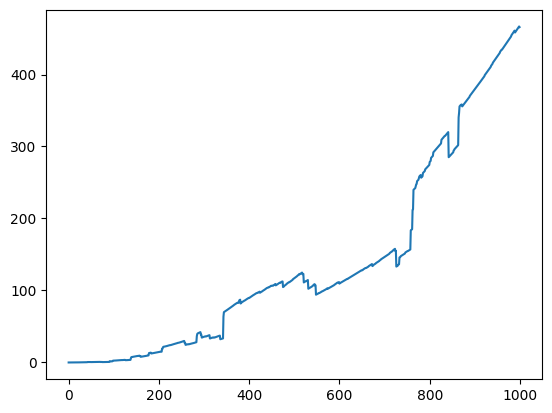

In [92]:
plt.plot(triangle_estimates_test)

---

We now use the whole dataset of almost 1.5 million edges.

In [93]:
st = StreamingTriangles(NetworkEdgeStream("web-NotreDame.txt", True), 1225, 1500)

In [94]:
results = []
for e in st.run_return_estimates():
  results.append(e)

100%|██████████| 1497138/1497138 [03:16<00:00, 7604.61it/s]


The estimated count towards the end is around 3 million compared to the actual number of almost 9 million. If the provided number contains duplicates, the estimate will be extremely accurate, as then we would need to divide by three and get our estimate, but even if it is correct, then the result is still very good when we take into consideration the fact that we only ever saved $\sqrt{n}$ edges, where $n$ is the number of edges in the dataset, and just a few more wedges, which results in a space saving of around 99.71%.

In [95]:
triangle_estimates = np.array(list(map(lambda x:x[1], results)))
median_count, mean_count, max_count = np.median(triangle_estimates), np.mean(triangle_estimates), np.max(triangle_estimates)
print(f"Median:\t{int(median_count)}\nMean:\t{int(mean_count)}\nMax:\t{int(max_count)}\nFinal:\t{round(results[-1][1])}\nActual:\t{8910005}")

Median:	5196180
Mean:	11348684
Max:	35057991
Final:	35027827
Actual:	8910005


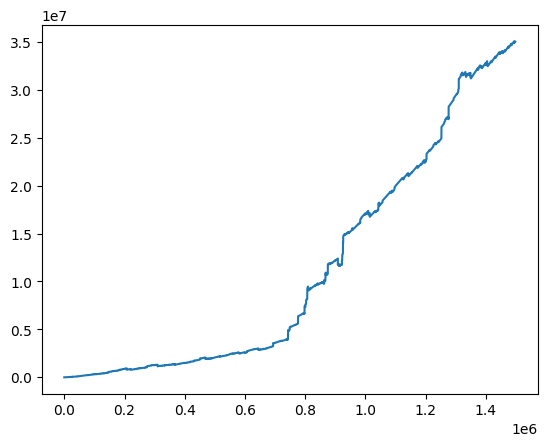

In [96]:
plt.plot(triangle_estimates)